# Reproduction of grokking on modular addition problem

## Step 1: Produce dataset
I start by producing a simple algorithmic dataset, similar to the one in the core paper. The network will be trained to evaluate an expression of the type (a + b) mod p, where a and b are numbered inputs and p is a prime number.

In [1]:
# Imports
import os
import datetime
import random
import einops
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from notebook import notebookapp

import torch 
import torch.nn as nn
import torch.nn.functional as F

seed = 0
local_host = True if 'oveggeland' in list(notebookapp.list_running_servers())[0]['notebook_dir'] else False

In [2]:
def get_datasets(train_frac=0.5, p=97):

    # Create a randomly shuffled list of all possible combinations of input numbers: (i+j) % p = ?
    pairs = [(i, j, p) for i in range(p) for j in range(p)]
    random.shuffle(pairs)

    # Divide list into train and validation sets
    div = int(train_frac*len(pairs))
    train_set, val_set = pairs[:div], pairs[div:]
    
    return train_set, val_set
    

## Step 2: Define model (2L decoder only transformer)
Using NEEL NANDAS (INTERPRETABILITY) as inspiration

In [3]:
# A helper class to get access to intermediate activations (inspired by Garcon)
# It's a dummy module that is the identity function by default
# I can wrap any intermediate activation in a HookPoint and get a convenient 
# way to add PyTorch hooks
class HookPoint(nn.Module):
    def __init__(self):
        super().__init__()
        self.fwd_hooks = []
        self.bwd_hooks = []
    
    def give_name(self, name):
        # Called by the model at initialisation
        self.name = name
    
    def add_hook(self, hook, dir='fwd'):
        # Hook format is fn(activation, hook_name)
        # Change it into PyTorch hook format (this includes input and output, 
        # which are the same for a HookPoint)
        def full_hook(module, module_input, module_output):
            return hook(module_output, name=self.name)
        if dir=='fwd':
            handle = self.register_forward_hook(full_hook)
            self.fwd_hooks.append(handle)
        elif dir=='bwd':
            handle = self.register_backward_hook(full_hook)
            self.bwd_hooks.append(handle)
        else:
            raise ValueError(f"Invalid direction {dir}")
    
    def remove_hooks(self, dir='fwd'):
        if (dir=='fwd') or (dir=='both'):
            for hook in self.fwd_hooks:
                hook.remove()
            self.fwd_hooks = []
        if (dir=='bwd') or (dir=='both'):
            for hook in self.bwd_hooks:
                hook.remove()
            self.bwd_hooks = []
        if dir not in ['fwd', 'bwd', 'both']:
            raise ValueError(f"Invalid direction {dir}")
    
    def forward(self, x):
        return x

In [4]:
# Define network architecture
# I defined my own transformer from scratch so I'd fully understand each component 
# - I expect this wasn't necessary or particularly important, and a bunch of this 
# replicates existing PyTorch functionality

# Embed & Unembed
class Embed(nn.Module):
    def __init__(self, d_vocab, d_model):
        super().__init__()
        self.W_E = nn.Parameter(torch.randn(d_model, d_vocab)/np.sqrt(d_model))
    
    def forward(self, x):
        return torch.einsum('dbp -> bpd', self.W_E[:, x])

class Unembed(nn.Module):
    def __init__(self, d_vocab, d_model):
        super().__init__()
        self.W_U = nn.Parameter(torch.randn(d_model, d_vocab)/np.sqrt(d_vocab))
    
    def forward(self, x):
        return (x @ self.W_U)

# Positional Embeddings
class PosEmbed(nn.Module):
    def __init__(self, max_ctx, d_model):
        super().__init__()
        self.W_pos = nn.Parameter(torch.randn(max_ctx, d_model)/np.sqrt(d_model))
    
    def forward(self, x):
        return x+self.W_pos[:x.shape[-2]]

# LayerNorm
class LayerNorm(nn.Module):
    def __init__(self, d_model, epsilon = 1e-4, model=[None]):
        super().__init__()
        self.model = model
        self.w_ln = nn.Parameter(torch.ones(d_model))
        self.b_ln = nn.Parameter(torch.zeros(d_model))
        self.epsilon = epsilon
    
    def forward(self, x):
        if self.model[0].use_ln:
            x = x - x.mean(axis=-1)[..., None]
            x = x / (x.std(axis=-1)[..., None] + self.epsilon)
            x = x * self.w_ln
            x = x + self.b_ln
            return x
        else:
            return x

# Attention
class Attention(nn.Module):
    def __init__(self, d_model, num_heads, d_head, n_ctx, model):
        super().__init__()
        self.model = model
        self.W_K = nn.Parameter(torch.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_Q = nn.Parameter(torch.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_V = nn.Parameter(torch.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_O = nn.Parameter(torch.randn(d_model, d_head * num_heads)/np.sqrt(d_model))
        self.register_buffer('mask', torch.tril(torch.ones((n_ctx, n_ctx))))
        self.d_head = d_head
        self.hook_k = HookPoint()
        self.hook_q = HookPoint()
        self.hook_v = HookPoint()
        self.hook_z = HookPoint()
        self.hook_attn = HookPoint()
        self.hook_attn_pre = HookPoint()

    def forward(self, x):
        k = self.hook_k(torch.einsum('ihd,bpd->biph', self.W_K, x))
        q = self.hook_q(torch.einsum('ihd,bpd->biph', self.W_Q, x))
        v = self.hook_v(torch.einsum('ihd,bpd->biph', self.W_V, x))
        attn_scores_pre = torch.einsum('biph,biqh->biqp', k, q)
        attn_scores_masked = torch.tril(attn_scores_pre) - 1e10 * (1 - self.mask[:x.shape[-2], :x.shape[-2]])
        attn_matrix = self.hook_attn(F.softmax(self.hook_attn_pre(attn_scores_masked/np.sqrt(self.d_head)), dim=-1))
        z = self.hook_z(torch.einsum('biph,biqp->biqh', v, attn_matrix))
        z_flat = einops.rearrange(z, 'b i q h -> b q (i h)')
        out = torch.einsum('df,bqf->bqd', self.W_O, z_flat)
        return out

# MLP Layers
class MLP(nn.Module):
    def __init__(self, d_model, d_mlp, act_type, model):
        super().__init__()
        self.model = model
        self.W_in = nn.Parameter(torch.randn(d_mlp, d_model)/np.sqrt(d_model))
        self.b_in = nn.Parameter(torch.zeros(d_mlp))
        self.W_out = nn.Parameter(torch.randn(d_model, d_mlp)/np.sqrt(d_model))
        self.b_out = nn.Parameter(torch.zeros(d_model))
        self.act_type = act_type
        # self.ln = LayerNorm(d_mlp, model=self.model)
        self.hook_pre = HookPoint()
        self.hook_post = HookPoint()
        assert act_type in ['ReLU', 'GeLU']
        
    def forward(self, x):
        x = self.hook_pre(torch.einsum('md,bpd->bpm', self.W_in, x) + self.b_in)
        if self.act_type=='ReLU':
            x = F.relu(x)
        elif self.act_type=='GeLU':
            x = F.gelu(x)
        x = self.hook_post(x)
        x = torch.einsum('dm,bpm->bpd', self.W_out, x) + self.b_out
        return x

# Transformer Block
class TransformerBlock(nn.Module):
    def __init__(self, d_model, d_mlp, d_head, num_heads, n_ctx, act_type, model):
        super().__init__()
        self.model = model
        # self.ln1 = LayerNorm(d_model, model=self.model)
        self.attn = Attention(d_model, num_heads, d_head, n_ctx, model=self.model)
        # self.ln2 = LayerNorm(d_model, model=self.model)
        self.mlp = MLP(d_model, d_mlp, act_type, model=self.model)
        self.hook_attn_out = HookPoint()
        self.hook_mlp_out = HookPoint()
        self.hook_resid_pre = HookPoint()
        self.hook_resid_mid = HookPoint()
        self.hook_resid_post = HookPoint()
    
    def forward(self, x):
        x = self.hook_resid_mid(x + self.hook_attn_out(self.attn((self.hook_resid_pre(x)))))
        x = self.hook_resid_post(x + self.hook_mlp_out(self.mlp((x))))
        return x

# Full transformer
class Transformer(nn.Module):
    def __init__(self, num_layers, d_vocab, d_model, d_mlp, d_head, num_heads, n_ctx, act_type, use_cache=False, use_ln=True):
        super().__init__()
        self.cache = {}
        self.use_cache = use_cache

        self.embed = Embed(d_vocab, d_model)
        self.pos_embed = PosEmbed(n_ctx, d_model)
        self.blocks = nn.ModuleList([TransformerBlock(d_model, d_mlp, d_head, num_heads, n_ctx, act_type, model=[self]) for i in range(num_layers)])
        # self.ln = LayerNorm(d_model, model=[self])
        self.unembed = Unembed(d_vocab, d_model)
        self.use_ln = use_ln

        for name, module in self.named_modules():
            if type(module)==HookPoint:
                module.give_name(name)
    
    def forward(self, x):
        x = self.embed(x)
        x = self.pos_embed(x)
        for block in self.blocks:
            x = block(x)
        # x = self.ln(x)
        x = self.unembed(x)
        return x

    def set_use_cache(self, use_cache):
        self.use_cache = use_cache
    
    def hook_points(self):
        return [module for name, module in self.named_modules() if 'hook' in name]

    def remove_all_hooks(self):
        for hp in self.hook_points():
            hp.remove_hooks('fwd')
            hp.remove_hooks('bwd')
    
    def cache_all(self, cache, incl_bwd=False):
        # Caches all activations wrapped in a HookPoint
        def save_hook(tensor, name):
            cache[name] = tensor.detach()
        def save_hook_back(tensor, name):
            cache[name+'_grad'] = tensor[0].detach()
        for hp in self.hook_points():
            hp.add_hook(save_hook, 'fwd')
            if incl_bwd:
                hp.add_hook(save_hook_back, 'bwd')

## Step 3: Training the model

In [5]:
# Helper function for model training

def full_loss(model, data, device):
    # Take the final position only
    logits = model(data)[:, -1]
    labels = torch.tensor([fn(i, j) for i, j, _ in data]).to(device)
    
    int_logits = np.argmax(logits.cpu().detach().numpy().squeeze(), axis=1).astype(int)
    int_labels = labels.int().cpu().numpy().squeeze()
    
    correct = int_logits == int_labels
    
    return cross_entropy_high_precision(logits, labels), correct.sum() / int_labels.size

def cross_entropy_high_precision(logits, labels):
    # Shapes: batch x vocab, batch
    # Cast logits to float64 because log_softmax has a float32 underflow on overly 
    # confident data and can only return multiples of 1.2e-7 (the smallest float x
    # such that 1+x is different from 1 in float32). This leads to loss spikes 
    # and dodgy gradients
    logprobs = F.log_softmax(logits.to(torch.float64), dim=-1)
    prediction_logprobs = torch.gather(logprobs, index=labels[:, None], dim=-1)
    loss = -torch.mean(prediction_logprobs)
    
    return loss

In [9]:
def run_exp(run_name=f"test__"+datetime.datetime.now().strftime("%Y_%m_%d__%H_%M_%S")):
    # Seeds for reproducability
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    # Init model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = Transformer(num_layers=num_layers, d_vocab=d_vocab, d_model=d_model, d_mlp=d_mlp, d_head=d_head, num_heads=num_heads, n_ctx=n_ctx, act_type=act_type, use_cache=False, use_ln=use_ln)
    model.to(device)

    # Define optimizing process
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay, betas=(0.9, 0.98))
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda step: min(step/10, 1))

    # Run formalities
    try:
        os.mkdir(save_root/run_name)
    except:
        print("Folder already exists")
        
    # Allocate lists for loss storage
    train_losses = []
    val_losses = []
    
    train_acc = []
    val_acc = []
    
    # Get dataset
    train_set, val_set = get_datasets(train_frac=train_frac, p=p)

    # Train over several epochs
    for epoch in range(num_epochs):
        # Calculate train and val loss
        train_loss, epoch_train_acc = full_loss(model, train_set, device)
        train_losses.append(train_loss.item())

        val_loss, epoch_val_acc = full_loss(model, val_set, device)
        val_losses.append(val_loss.item())
        
        # Accuracy
        train_acc.append(epoch_train_acc)
        val_acc.append(epoch_val_acc)
    
        # Print status
        if epoch%100 == 0: 
            print(f"{epoch}_{np.log(train_loss.item()):.4f}_{np.log(val_loss.item()):.4f}")
            print(f"{epoch}_{epoch_train_acc}_{epoch_val_acc}")

        # Calc gradients and perform backprop
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        scheduler.step()

        if val_loss.item() < stopping_thresh:
            break

        if (save_models) and (epoch%save_every == 0):
            if val_loss.item() < stopping_thresh:
                break
            save_dict = {
                'model': model.state_dict(),
                'epoch': epoch,
            }
            torch.save(save_dict, save_root/run_name/f"{epoch}.pth")
            print(f"Saved model to {save_root/run_name/f'{epoch}.pth'}")

    if not save_models:
        os.mkdir(save_root/run_name)
    save_dict = {
        'model': model.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_acc': train_acc,
        'val_acc': val_acc
    }

    torch.save(save_dict, save_root/run_name/f"final.pth")
    print(f"Saved model to {save_root/run_name/f'final.pth'}")

# Step 4: Run experiments

In [ ]:
lr=1e-3
weight_decay = 1
train_frac = 0.5
d_model = 128
num_epochs = 5000
save_models = True
save_every = 100
save_root = Path("checkpoints") # Path("PhD/IMT4392/project/modulo/checkpoints") if not local_host else Path("checkpoints")
stopping_thresh = -1
seed = 0
fn_name = 'add' #['add', 'subtract', 'x2xyy2','rand']

# Model parameters
num_layers = 1
batch_style = 'full'
p = 97
d_vocab = p+1
n_ctx = 3
d_mlp = 4*d_model
num_heads = 4
assert d_model % num_heads == 0, "Error with parameters"
d_head = d_model//num_heads
act_type = 'ReLU' #@param ['ReLU', 'GeLU']
use_ln = False
random_answers = np.random.randint(low=0, high=p, size=(p, p))
fns_dict = {'add': lambda x,y:(x+y)%p, 'subtract': lambda x,y:(x-y)%p, 'x2xyy2':lambda x,y:(x**2+x*y+y**2)%p, 'rand':lambda x,y:random_answers[x][y]}
fn = fns_dict[fn_name]


# Run a lot of experiments
train_fracs = [0.5]
decays = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
tag = fn_name

for frac in train_fracs:
    for decay in decays:
        train_frac = frac
        weight_decay = decay
        
        exp_name = f"{tag}_{weight_decay}decay_{train_frac}train"
        run_exp(exp_name)

Folder already exists
0_1.5315_1.5311
0_0.009141156462585034_0.012327311370882041
Saved model to checkpoints/add_0.0decay_0.5train/0.pth
100_0.6026_1.8339
100_0.6181972789115646_0.09160467587672688
Saved model to checkpoints/add_0.0decay_0.5train/100.pth
200_-5.5617_2.2586
200_1.0_0.48034006376195537
Saved model to checkpoints/add_0.0decay_0.5train/200.pth
300_-7.0418_2.3626
300_1.0_0.4811902231668438
Saved model to checkpoints/add_0.0decay_0.5train/300.pth
400_-8.3372_2.4434
400_1.0_0.4814027630180659
Saved model to checkpoints/add_0.0decay_0.5train/400.pth
500_-9.5651_2.5134
500_1.0_0.481615302869288
Saved model to checkpoints/add_0.0decay_0.5train/500.pth
600_-10.7588_2.5763
600_1.0_0.481615302869288
Saved model to checkpoints/add_0.0decay_0.5train/600.pth
700_-11.9278_2.6337
700_1.0_0.4820403825717322
Saved model to checkpoints/add_0.0decay_0.5train/700.pth
800_-13.0744_2.6865
800_1.0_0.4822529224229543
Saved model to checkpoints/add_0.0decay_0.5train/800.pth
900_-14.1953_2.7353
90

2600_-17.6240_2.4709
2600_1.0_0.48799149840595113
Saved model to checkpoints/add_0.1decay_0.5train/2600.pth
2700_-17.6260_2.4558
2700_1.0_0.48862911795961744
Saved model to checkpoints/add_0.1decay_0.5train/2700.pth
2800_-17.6286_2.4405
2800_1.0_0.48947927736450586
Saved model to checkpoints/add_0.1decay_0.5train/2800.pth
2900_-17.6306_2.4250
2900_1.0_0.4903294367693943
Saved model to checkpoints/add_0.1decay_0.5train/2900.pth
3000_-17.6324_2.4093
3000_1.0_0.4907545164718385
Saved model to checkpoints/add_0.1decay_0.5train/3000.pth
3100_-17.6349_2.3934
3100_1.0_0.4913921360255048
Saved model to checkpoints/add_0.1decay_0.5train/3100.pth
3200_-17.6374_2.3773
3200_1.0_0.4926673751328374
Saved model to checkpoints/add_0.1decay_0.5train/3200.pth
3300_-17.6400_2.3611
3300_1.0_0.49415515409139216
Saved model to checkpoints/add_0.1decay_0.5train/3300.pth
3400_-17.6422_2.3448
3400_1.0_0.49436769394261426
Saved model to checkpoints/add_0.1decay_0.5train/3400.pth
3500_-17.6451_2.3281
3500_1.0_0.

# Step 5: Analysis

## Single grokking example

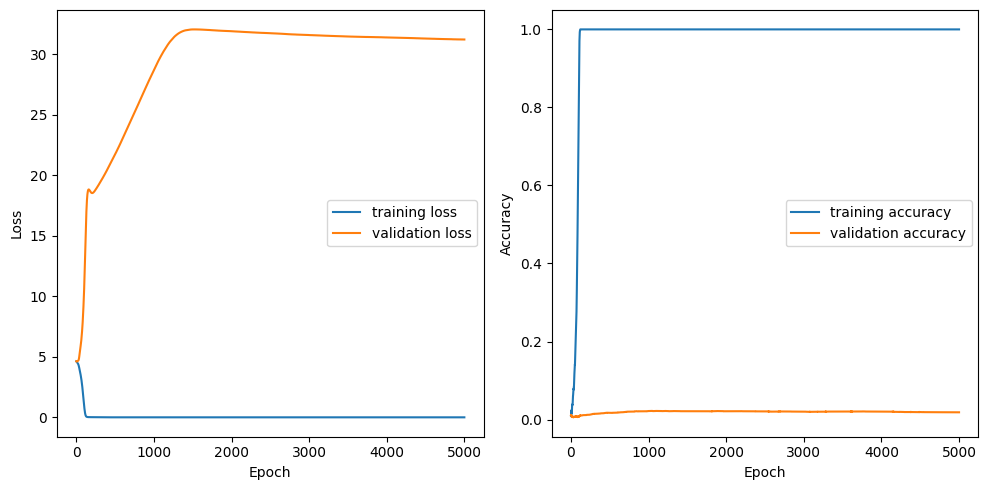

In [76]:
# Show grokking effect

load_dict = torch.load(f"checkpoints/add_1decay_0.2train/final.pth", map_location=torch.device('cpu'))
    
fig, axs = plt.subplots(1, 2, figsize=(10, 5))


axs[0].plot(load_dict['train_losses'], label='training loss')
axs[0].plot(load_dict['val_losses'], label="validation loss")

axs[1].plot(load_dict['train_acc'], label='training accuracy')
axs[1].plot(load_dict['val_acc'], label="validation accuracy")
    
axs[0].set_xlabel("Epoch")
axs[1].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[1].set_ylabel("Accuracy")
axs[0].legend()
axs[1].legend()


plt.tight_layout()

## The effect of training size ratio

In [ ]:
# Show how the amount of training data effects fraccing
fig, axs = plt.subplots(1, 2, figsize=(10, 5)) 
colors = ['r', 'g', 'b', 'c', 'm']

decay = 1
train_fracs = [0.1, 0.2, 0.3, 0.4, 0.5]
tag = 'add'

for i, frac in enumerate(train_fracs):
    exp_name = f"{tag}_{decay}decay_{frac}train"
    load_dict = torch.load(f"checkpoints/{exp_name}/final.pth", map_location=torch.device('cpu'))
    
    axs[0].plot(load_dict['train_losses'], linestyle='dashed', c=colors[i])
    axs[0].plot(load_dict['val_losses'], c=colors[i], label=f"{frac}")
    
    axs[1].plot(load_dict['train_acc'], linestyle='dashed', c=colors[i])
    axs[1].plot(load_dict['val_acc'], c=colors[i], label=f"{int(100*frac)}% train")
    

axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")

axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()

plt.show()
plt.tight_layout()
plt.savefig("modulo_training_size")

## The effect of weigth decay 

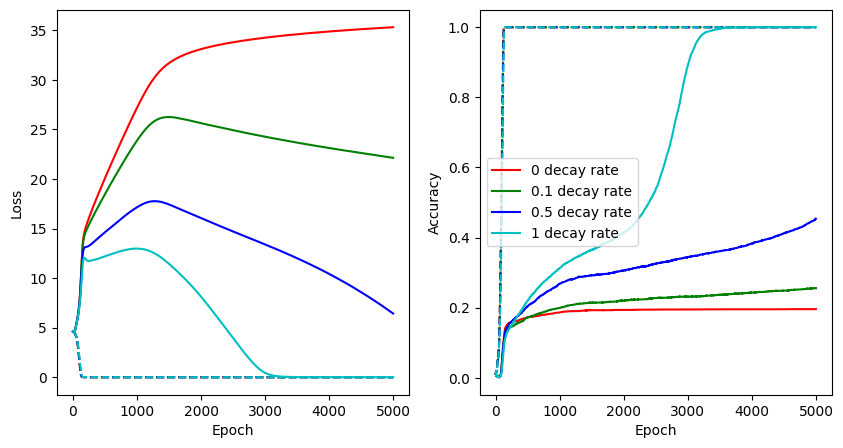

In [92]:
# Show how the amount of training data effects fraccing
fig, axs = plt.subplots(1, 2, figsize=(10, 5)) 
colors = ['r', 'g', 'b', 'c', 'm']

train_frac = 0.4
decays = [0, 0.1, 0.5, 1]
tag = 'add'

for i, decay in enumerate(decays):
    exp_name = f"{tag}_{decay}decay_{train_frac}train"
    load_dict = torch.load(f"checkpoints/{exp_name}/final.pth",  map_location=torch.device('cpu'))
    
    axs[0].plot(load_dict['train_losses'], linestyle='dashed', c=colors[i])
    axs[0].plot(load_dict['val_losses'], c=colors[i], label=f"{decay}")
    
    axs[1].plot(load_dict['train_acc'], linestyle='dashed', c=colors[i])
    axs[1].plot(load_dict['val_acc'], c=colors[i], label=f"{decay} decay rate")
    

axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")

axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()

plt.show()